# Tesla Stock Price Prediction using RNN/LSTM

## Visão Geral do Projeto

Este notebook implementa um modelo de Rede Neural Recorrente (RNN) usando LSTM para predição dos preços das ações da Tesla no período de 2010-2024.

### Dataset
**Fonte**: Tesla Stock Price Dataset 2010-2024 (Kaggle)

### Colunas do Dataset
- **Date**: Data da negociação
- **Close**: Preço de fechamento da ação (variável target)
- **Open, High, Low**: Preços de abertura, máximo e mínimo diários
- **Volume**: Volume de negociações

### Métrica Selecionada: RMSE (Root Mean Square Error)

**Justificativa**: Para problemas de regressão em séries temporais financeiras, o RMSE é ideal porque:
- Penaliza mais severamente erros grandes (crucial em finanças)
- Mantém a mesma unidade da variável target (dólares)
- Permite comparação direta com o valor médio dos preços
- É sensível a outliers, importante para detectar falhas do modelo em movimentos extremos

### Abordagem Técnica

1. **Transformação Logarítmica**: Aplicada aos preços para linearizar o crescimento exponencial da Tesla
2. **Normalização**: MinMaxScaler nos dados log-transformados
3. **Sequências**: Janela de 20 dias para predizer o próximo dia
4. **Split Temporal**: Divisão em 2019 para evitar o período volátil de 2020-2021 no conjunto de teste
5. **Arquitetura**: LSTM dupla com Dropout para regularização

### Objetivos
- Avaliar a capacidade preditiva de RNNs em ações de alta volatilidade
- Quantificar o erro de predição usando métricas robustas
- Visualizar performance através de comparação gráfica

## Importação de Bibliotecas
Carregamento de todas as dependências necessárias para processamento de dados, modelagem com LSTM e visualização.

In [10]:
"""
ponderada_rnn-mauro_das_chagas_junior.ipynb

Tesla Stock Price Prediction using RNN/LSTM - Back to Basics
Dataset: Tesla Stock Price Dataset 2010-2024 (Kaggle)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('tesla_stock_price_14_years.csv')

## Carregamento dos Dados
Leitura do dataset Tesla e ordenação cronológica para manter a sequência temporal.

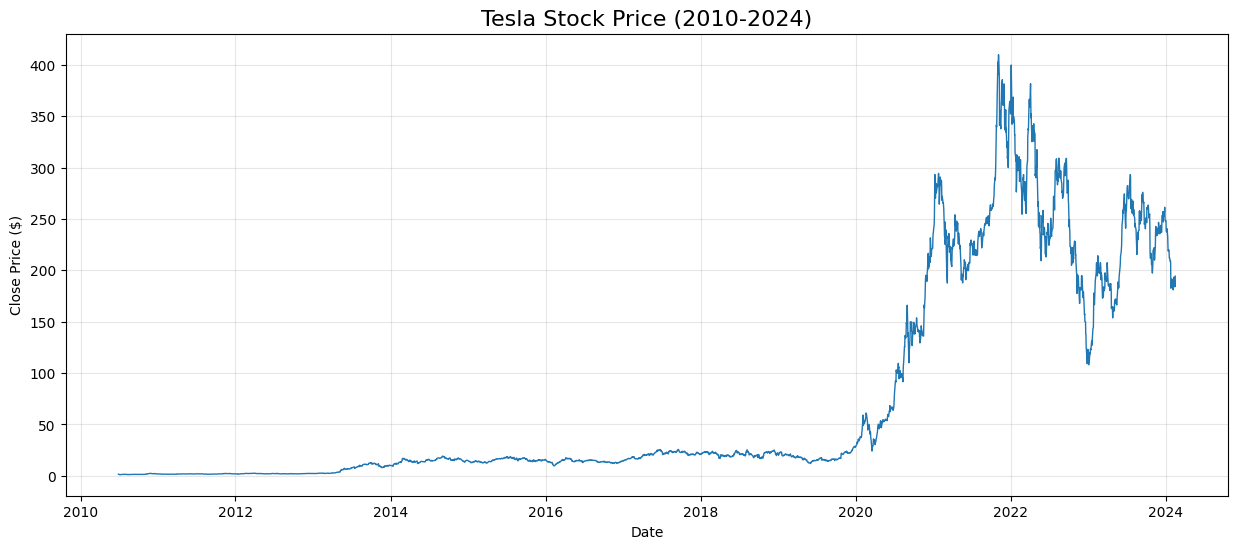


Period: 2010-06-29 00:00:00 to 2024-02-15 00:00:00
Total trading days: 3432
Price range: $1.05 - $409.97


In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Plot stock price
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'], linewidth=1)
plt.title('Tesla Stock Price (2010-2024)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nPeriod: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total trading days: {len(df)}")
print(f"Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")

## Pré-processamento: Transformação Logarítmica
Aplicação de log transformation para linearizar o crescimento exponencial e normalização com MinMaxScaler.

Função para criar sequências de 20 dias consecutivos como entrada e o dia seguinte como target.

Split estratégico em 2019 para usar período pré-pandemia como treino e pós-2019 como teste.

In [12]:
# Use log transformation to handle extreme price growth
df['Log_Close'] = np.log(df['Close'])
data = df['Log_Close'].values.reshape(-1, 1)

# Scale log prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 20

X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split at 2019 - avoid the crazy 2020-2021 period for testing
split_date = '2019-01-01'
split_idx = df[df['Date'] < split_date].shape[0] - SEQ_LENGTH

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Get the actual dates for plotting
train_dates = df['Date'][SEQ_LENGTH:SEQ_LENGTH + len(X_train)]
test_dates = df['Date'][SEQ_LENGTH + split_idx:SEQ_LENGTH + split_idx + len(X_test)]

print(f"Training period: {train_dates.iloc[0]} to {train_dates.iloc[-1]}")
print(f"Test period: {test_dates.iloc[0]} to {test_dates.iloc[-1]}")


Training set shape: (2122, 20, 1)
Test set shape: (1290, 20, 1)
Training period: 2010-07-28 00:00:00 to 2018-12-31 00:00:00
Test period: 2019-01-02 00:00:00 to 2024-02-15 00:00:00


## Arquitetura da Rede Neural
Modelo LSTM sequencial com duas camadas LSTM, dropout para regularização e camada densa final.

Training com early stopping para evitar overfitting, usando 15% dos dados de treino para validação.

In [13]:
# Simple but effective model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(25, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nModel Summary:")
model.summary()

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)


Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 4.2297e-04 - val_mae: 0.0182
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0062 - mae: 0.0585 - val_loss: 9.5679e-04 - val_mae: 0.0291
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0700 - val_loss: 9.3761e-04 - val_mae: 0.0289
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0080 - mae: 0.0664 - val_loss: 8.1865e-04 - val_mae: 0.0269
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - mae: 0.0593 - val_loss: 5.7996e-04 - val_mae: 0.0222
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - mae: 0.0437 - val_loss: 1.8399e-04 - val_mae: 0.0112
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 4.3803e-04 - val_mae: 0.0190
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7640e-04 - mae: 0.0215 - val_loss: 2.7532e-04 - val_mae

## Visualização do Histórico de Treinamento
Plotagem das curvas de loss e MAE para treino e validação ao longo das épocas.

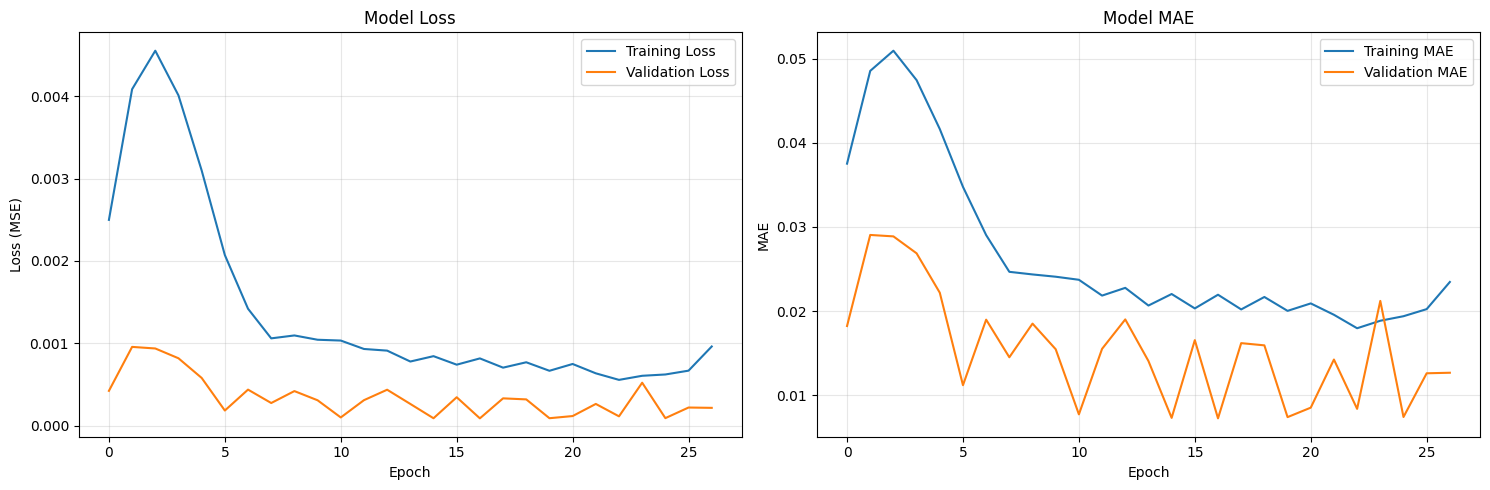

In [14]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title('Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Geração de Predições
Aplicação do modelo treinado nos conjuntos de treino e teste.

Conversão das predições de volta para escala original: desnormalização + exponencial.

Cálculo das métricas de performance: RMSE, MAE, MAPE e R² Score.

In [15]:
# Make predictions
train_pred_scaled = model.predict(X_train, verbose=0)
test_pred_scaled = model.predict(X_test, verbose=0)

# Convert back to log scale
train_pred_log = scaler.inverse_transform(train_pred_scaled)
test_pred_log = scaler.inverse_transform(test_pred_scaled)
train_actual_log = scaler.inverse_transform(y_train.reshape(-1, 1))
test_actual_log = scaler.inverse_transform(y_test.reshape(-1, 1))

# Convert from log scale to actual prices
train_pred_prices = np.exp(train_pred_log).flatten()
test_pred_prices = np.exp(test_pred_log).flatten()
train_actual_prices = np.exp(train_actual_log).flatten()
test_actual_prices = np.exp(test_actual_log).flatten()

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(train_actual_prices, train_pred_prices))
test_rmse = np.sqrt(mean_squared_error(test_actual_prices, test_pred_prices))
test_mae = mean_absolute_error(test_actual_prices, test_pred_prices)
test_mape = mean_absolute_percentage_error(test_actual_prices, test_pred_prices)
test_r2 = r2_score(test_actual_prices, test_pred_prices)


print("\n" + "="*50)
print("RESULTADOS FINAIS (MÉTRICA: RMSE)")
print("="*50)
print(f"Training RMSE: ${train_rmse:.2f}")
print(f"Test RMSE: ${test_rmse:.2f}")
print(f"Relative Error: {(test_rmse/np.mean(test_actual_prices))*100:.2f}%")

print("\n" + "="*50)
print("MÉTRICAS ADICIONAIS:")
print("="*50)
print(f"MAE (Mean Absolute Error): ${test_mae:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {test_mape*100:.2f}%")
print(f"R² Score: {test_r2:.4f}")

# Debug prediction ranges
print(f"\nRanges de predição:")
print(f"Train predictions: ${train_pred_prices.min():.2f} - ${train_pred_prices.max():.2f}")
print(f"Test predictions: ${test_pred_prices.min():.2f} - ${test_pred_prices.max():.2f}")
print(f"Train actual: ${train_actual_prices.min():.2f} - ${train_actual_prices.max():.2f}")
print(f"Test actual: ${test_actual_prices.min():.2f} - ${test_actual_prices.max():.2f}")



RESULTADOS FINAIS (MÉTRICA: RMSE)
Training RMSE: $0.83
Test RMSE: $122.59
Relative Error: 71.37%

MÉTRICAS ADICIONAIS:
MAE (Mean Absolute Error): $98.00
MAPE (Mean Absolute Percentage Error): 43.79%
R² Score: -0.3100

Ranges de predição:
Train predictions: $1.09 - $23.80
Test predictions: $13.49 - $123.25
Train actual: $1.17 - $25.67
Test actual: $11.93 - $409.97


## Visualização dos Resultados
Comparação gráfica entre valores reais e preditos para todo o período e zoom no período de teste.

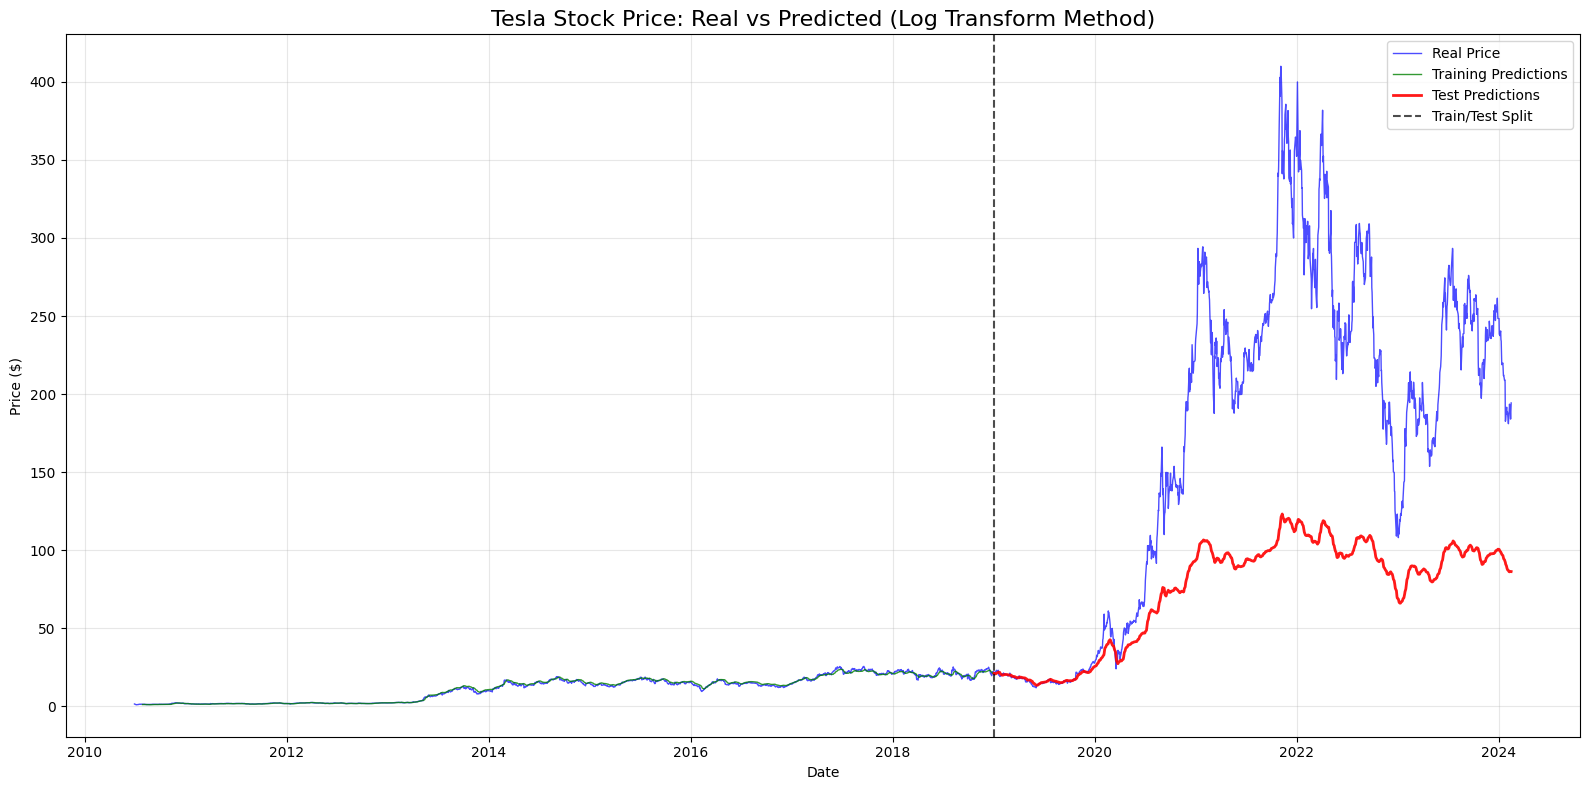

In [16]:
# Plot results
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], df['Close'], label='Real Price', color='blue', alpha=0.7, linewidth=1)
plt.plot(train_dates, train_pred_prices, label='Training Predictions', color='green', alpha=0.8, linewidth=1)
plt.plot(test_dates, test_pred_prices, label='Test Predictions', color='red', alpha=0.9, linewidth=2)
plt.axvline(x=test_dates.iloc[0], color='black', linestyle='--', alpha=0.7, label='Train/Test Split')
plt.title('Tesla Stock Price: Real vs Predicted (Log Transform Method)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

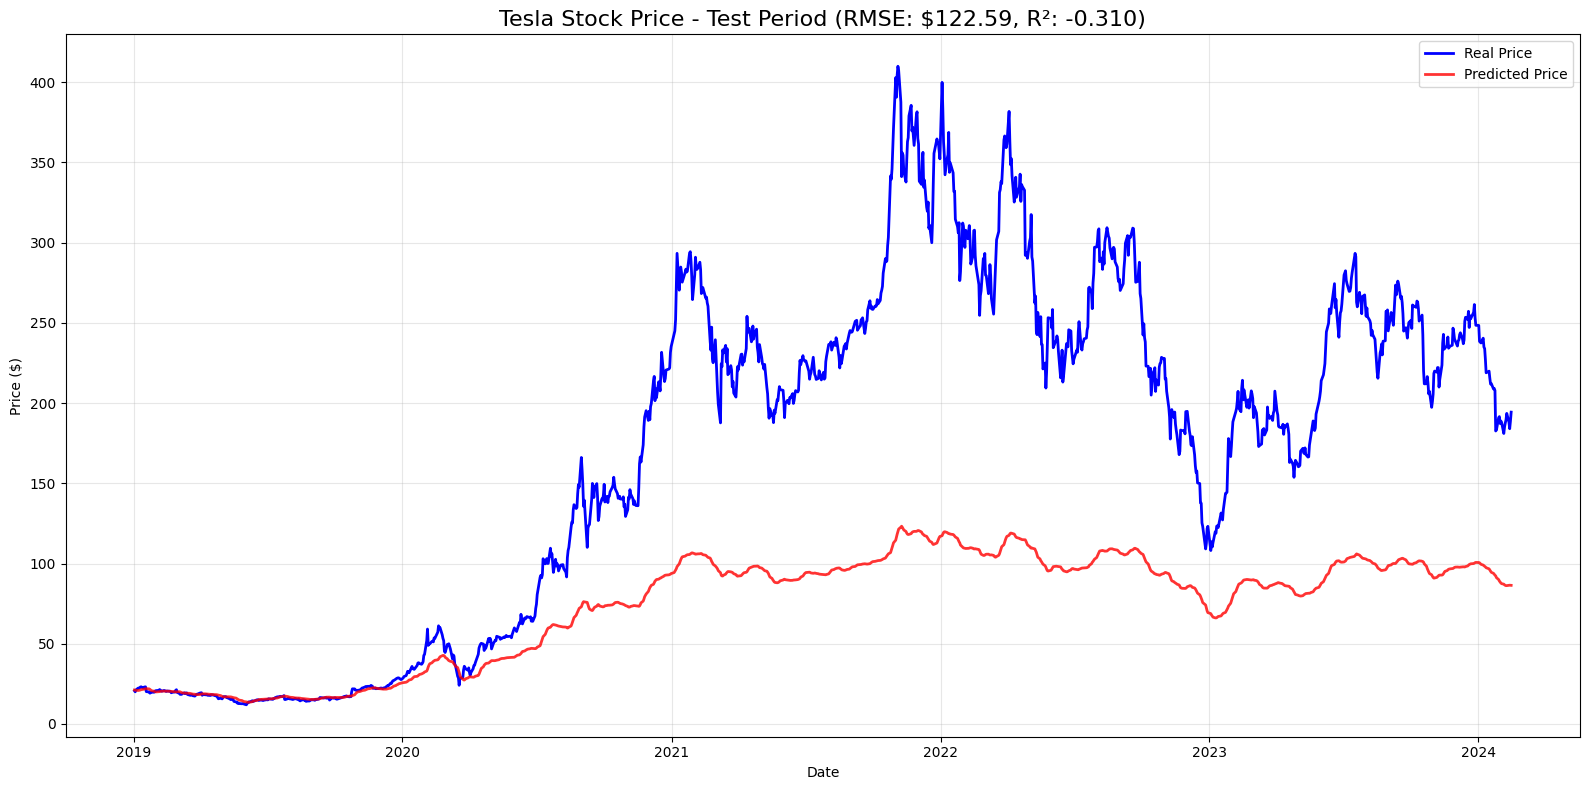

In [17]:
# Zoom on test period
plt.figure(figsize=(16, 8))
plt.plot(test_dates, test_actual_prices, label='Real Price', color='blue', linewidth=2)
plt.plot(test_dates, test_pred_prices, label='Predicted Price', color='red', linewidth=2, alpha=0.8)
plt.title(f'Tesla Stock Price - Test Period (RMSE: ${test_rmse:.2f}, R²: {test_r2:.3f})', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()